In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss: 2.3057, Train Acc: 0.2427, Val Loss: 3.5554, Val Acc: 0.2036
Epoch 2: Train Loss: 1.8085, Train Acc: 0.3673, Val Loss: 1.9754, Val Acc: 0.3745
Epoch 3: Train Loss: 1.6361, Train Acc: 0.4364, Val Loss: 1.7683, Val Acc: 0.4036
Epoch 4: Train Loss: 1.4630, Train Acc: 0.4800, Val Loss: 2.5856, Val Acc: 0.3818
Epoch 5: Train Loss: 1.3354, Train Acc: 0.5382, Val Loss: 1.8640, Val Acc: 0.4291
Epoch 6: Train Loss: 1.2641, Train Acc: 0.5764, Val Loss: 1.3871, Val Acc: 0.5636
Epoch 7: Train Loss: 1.1536, Train Acc: 0.6055, Val Loss: 2.5508, Val Acc: 0.3418
Epoch 8: Train Loss: 1.0704, Train Acc: 0.6109, Val Loss: 1.2029, Val Acc: 0.6255
Epoch 9: Train Loss: 0.9752, Train Acc: 0.6855, Val Loss: 1.2233, Val Acc: 0.6182
Epoch 10: Train Loss: 0.8311, Train Acc: 0.7036, Val Loss: 1.3220, Val Acc: 0.5782
Epoch 11: Train Loss: 0.7839, Train Acc: 0.7364, Val Loss: 1.3585, Val Acc: 0.5636
Epoch 12: Train Loss: 0.6461, Train Acc: 0.7764, Val Loss: 0.9443, Val Acc: 0.7055
Epoch 13: Tra

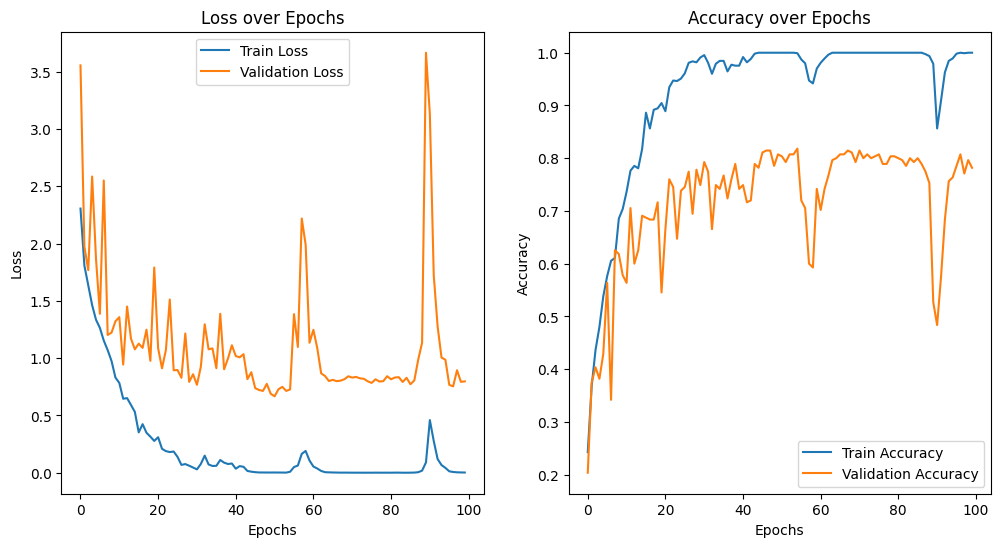

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {label: index for index, label in enumerate(sorted(set(self.data_frame.iloc[:, 1])))}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Ensure image is RGB format
        label_str = self.data_frame.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset and data loader
train_dataset = CustomDataset(
    csv_file='/content/drive/MyDrive/Colab Notebooks/labels.csv',
    root_dir='/content/drive/MyDrive/jpg',
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize ResNet model
model = models.resnet18(pretrained=False)  # False if not using pretrained
model.fc = nn.Linear(model.fc.in_features, 17)  # Adjust final layer to match number of classes

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Initialize lists to track the accuracies and losses
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training loop
for epoch in range(100):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)

    # Validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def ternarize(x, scale=0.5):
    x_tern = torch.zeros_like(x)
    x_tern[x > scale] = 1
    x_tern[x < -scale] = -1
    return x_tern

class TernaryConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(TernaryConv, self).__init__()
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def forward(self, x):
        tern_weights = ternarize(self.weight)
        return F.conv2d(x, tern_weights, self.bias, self.stride, self.padding)

class TernaryLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(TernaryLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None

    def forward(self, x):
        tern_weights = ternarize(self.weight)
        return F.linear(x, tern_weights, self.bias)

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = TernaryConv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = TernaryConv(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                TernaryConv(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = TernaryConv(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = TernaryLinear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

